<a href="https://colab.research.google.com/github/seanzhu815/402/blob/main/Assignment_2_Sample_code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 2 Solution

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### Import modules

In [4]:
import pandas            as pd   
import numpy             as np   
import scipy             as scp  
import matplotlib.pyplot as plt  
import os                as os   
from datetime import date as dd  # for dates
from scipy import optimize
from scipy import stats
import statsmodels.api as sm

In [5]:
np.set_printoptions(precision=2) # Set precision of numpy arrays while printing uless specified otherwise
#%% Set directories and define files
os.chdir(os.path.abspath(''))   # Change directory to location of the script
datafile1 = 'industry_returns.xlsx'

In [6]:
#%% Define helper function for Sharpe Ratio (Since this is used very frequently)
def Shratio(w,mu,Sigma,Rf): 
    portfolio_return = np.inner(mu, w) - Rf    # portfolio excess return
    portfolio_vol    = np.sqrt((w.T@Sigma@w))  # portfolio volatility
    return portfolio_return / portfolio_vol

In [7]:
#%% Read data
returns_data = pd.read_excel(datafile1, usecols = "B:M", header = 1)
dates = pd.read_excel(datafile1, usecols = "A", header = 1)
dates.columns = ['dates']
dates['dates'] = pd.to_datetime(dates['dates'],format='%Y%m')

FileNotFoundError: ignored

In [ ]:
# Set parameters
Rf = .04 / 12                         # monthly risk free rate
n = returns_data.shape[1]             # number of risky assets (columns)
T = returns_data.shape[0]             # number of observations (rows)
ret = returns_data / 100              # convert returns from percent to decimals
mu =                                  # mean returns 
Sigma =                               # covariance matrix

## Part 1

### Q 1.1

In [ ]:
# Unconstrained optimization:
w0 = np.ones((n,1)) / n  # starting weights
cons = ({'type' : 'eq', 'fun': lambda x: np.sum(x) - 1}) # portfolio weights sum to 1

sol = scp.optimize.minimize(lambda w: -Shratio(w, mu, Sigma, Rf), x0 = w0, constraints = cons)
w_uncon = sol.x
val_uncon = sol.fun

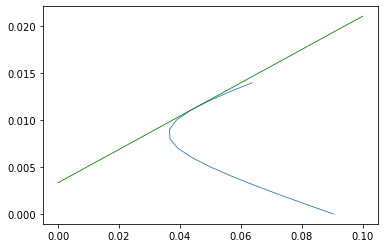

In [ ]:
# Construct EML
A = (mu.T.dot(np.linalg.inv(Sigma))).dot(mu)
B = mu.T.dot(np.linalg.solve(Sigma, np.ones((n,1))))
C = np.ones((n,1)).T.dot(np.linalg.solve(Sigma, np.ones((n,1))))
mu0 = np.arange(0,.015,.001)
varR0 = (C*(mu0**2) - 2*B*mu0 + A) /( A*C-B**2)
stdR0 = np.sqrt(varR0)
dummy = np.arange(0,np.max(stdR0)+.01, .01)
Sharpe_ratio = -val_uncon                                                # From the optimization above
Line_sharpe = Rf + Sharpe_ratio * dummy
plt.plot(stdR0.reshape((mu0.shape)), mu0, linewidth = .8)
plt.plot(dummy, Line_sharpe, color = 'green', linewidth = .8)
plt.show()

### Q 1.2:

In [ ]:
print(f'Annualized Sharpe ratio of tangency portfolio is {-np.sqrt(12) * val_uncon :.4}.')
print(f'Weights of tangency portfolio is {w_uncon}.')

Annualized Sharpe ratio of tangency portfolio is 0.6153.
Weights of tangency portfolio is [ 0.76  0.14 -0.03  0.3   0.01  0.16  0.21  0.04  0.05  0.35 -0.27 -0.72].


### Q 1.3:

In [ ]:
# 1.3: Constrained optimization
w0 = np.ones((n,1)) / n  # starting weights
cons = ({'type' : 'eq', 'fun': lambda x: np.sum(x) - 1}) # portfolio weights sum to 1
bnds = scp.optimize.Bounds(0,.25) # upper and lower bounds

sol =                             # Perfrom optimization here
w_con = sol.x
val_con = sol.fun
print(f'Annualized Sharpe ratio of tangency portfolio under constraints is {-np.sqrt(12) * val_con :.4}.')
print(f'Weights of tangency portfolio is {w_con}.')

Annualized Sharpe ratio of tangency portfolio under constraints is 0.5021.
Weights of tangency portfolio is [2.50e-01 0.00e+00 2.30e-17 2.09e-01 3.42e-02 0.00e+00 2.10e-01 0.00e+00
 4.70e-02 2.50e-01 0.00e+00 0.00e+00].


### Q 1.4:

In [ ]:
# 1.4: Training weights (Sample upto 2009)
ret_train = ret[dates['dates'].dt.year<2010]     # Training sample
ret_test = ret[dates['dates'].dt.year>=2010]     # Testing sample
mu =                                             # mean returns of the training sample
Sigma =                                          # covariance of the trainig sample
cons = ({'type' : 'eq', 'fun': lambda x: np.sum(x) - 1}) # portfolio weights sum to 1
sol =                                            # Solve the optimization problem for training weights.
w_train = sol.x
val_train = sol.fun
print(f' Optimal portfolio weights of of training data is {w_train}.')

 Optimal portfolio weights of of training data is [ 0.81  0.06 -0.01  0.41  0.09  0.1   0.27 -0.02 -0.04  0.27 -0.25 -0.69].


In [ ]:
# Test data Sharpe Ratio
mu_test =                                            # mean returns of testing set
Sigma_test =                                         # covariance matrix of testing set
val_test =                                           # Use the Shratio with approopriate weights
print(f'Annualized Sharpe using optimal training weights is {val_test:.4}')

Annualized Sharpe using optimal training weights is 0.4711


In [ ]:
# Equal weighted Sharpe Ratio
w_eq = np.ones((n)) / n  # Equal weights to all assets
val_test_eqweight =      # Use the Shratio with approopriate weights
print(f'Annualized Sharpe using equal weights is {val_test_eqweight:.4}')

Annualized Sharpe using equal weights is 0.6293


Thus the sharpe ratio with equal weights is better.

# Part 2: Momentum

### Q 2.1:

In [ ]:
#%% Part 2: Momentum
returns = returns_data.values
T = returns.shape[0]                   # Number of time periods
n = returns.shape[1]                   # Number of assets

avg_ret_11months = np.ones((T,n))      # Matrix with average returns for past 11 months for n firms
winner_portfolio_ret = np.ones((T,1))  # return of the winning portfolio
loser_portfolio_ret = np.ones((T,1))
winner_ind = np.ones((T,1))            # index  of winning industry in that month
loser_ind = np.ones((T,1))

# loop over time series, start from 1950/01
burn = sum((dates['dates'].dt.year<1950) == True) # Number of time periods before 1950/01 that must be "burned"

for i in range((burn+1),T): 
    # loop over industries
    for j in range(n):
        avg_ret_11months[i-1,j] =                  # take average of previous 11 months with one-skip-month
        
        sorted_ret = np.sort(avg_ret_11months[i-1,:])
        order = np.argsort(avg_ret_11months[i-1,:])
        
        long = order[xxx]                          # Index of the winner industry
        short = order[xxx]                         # Index of the loser industry
    
        winner_portfolio_ret[i] = returns[i,xxx]   
        loser_portfolio_ret[i] = returns[i,xxx]
    
        winner_ind[i] = long
        loser_ind[i] = short
    
spread = winner_portfolio_ret - loser_portfolio_ret

In [ ]:
# 2.1: Winner Minus Loser
wl_ret = pd.DataFrame(data=np.hstack((winner_portfolio_ret,loser_portfolio_ret,spread)), columns=["winner_ret", "loser_ret",'spread'])
wl_ret = wl_ret.loc[burn:]
print(f'Annualized average return for winner, loser and spread is {12*wl_ret.mean()} percent' )
print(f'Annualized standard deviation for winner, loser and spread is {np.sqrt(12)*wl_ret.std()} percent')

Annualized average return for winner, loser and spread is winner_ret    18.819885
loser_ret      8.368037
spread        10.451848
dtype: float64 percent
Annualized standard deviation for winner, loser and spread is winner_ret    20.395547
loser_ret     20.378370
spread        22.304593
dtype: float64 percent


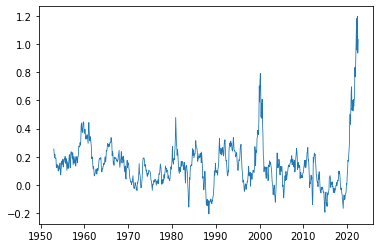

In [ ]:
# 2.2: Rolling time series (36 months)
wl_ret_rolling = wl_ret[["winner_ret", "loser_ret"]].rolling(36, min_periods=36).apply(lambda x: (np.prod(1.0+x/100)-1)/36*12)
wl_ret_rolling['spread'] =                         # Calculate the rolling spread
wl_ret_rolling['dates'] = dates[(burn+36):]
plt.plot()                                         # Plot the spread
plt.show()

### Q 2.3:

In [ ]:
# 2.3: Winner industries
winner_ind_df = pd.DataFrame(data= winner_ind[(burn+1):], columns=['industry'])
winner_count = winner_ind_df['industry'].value_counts() #number of times in winner portfolio
winner_order = returns_data.columns[winner_count.index.astype(int)].to_list()
print(f'From most often to least ofter, winner portfolio consists of {winner_order}' )


From most often to least ofter, winner portfolio consists of ['Enrgy', 'Durbl', 'Hlth ', 'BusEq', 'Telcm', 'Shops', 'Utils', 'Money', 'NoDur', 'Other', 'Manuf', 'Chems']


### Q 2.4: Do this yourself

### Q 2.5:

In [ ]:
# 2.5: Turnover
winner_turn = # Time series of number of 0 or 1. 1 if the winner changed from last time period
loser_turn =  # Same for loser
turnover_rate = sum(winner_turn|loser_turn)/(T-12)
print(f'frequency that either winner or loser portfolio changes is {turnover_rate:.4}' )


frequency that either winner or loser portfolio changes is 0.3883


### Q 2.6: Do this yourself

### Q 2.7

In [ ]:
# 2.7: Alpha
factors = pd.read_excel(datafile1, usecols = "O:Q", header = 1) #3 factors
#Rf = pd.read_excel(datafile1, usecols = "R", header = 0) #risk free rate
factors = factors[burn:] #3 factor

# spread
mod = sm.OLS(wl_ret['spread'],sm.add_constant( factors))
res = mod.fit()
res.summary()
print(f'alpha of wml is { res.params.const:.4}' )

# winner
mod = # Fill in the model
res = mod.fit()
res.summary()
print(f'alpha of winner is { res.params.const:.4}' )

# loser
mod = # Fill in the model
res = mod.fit()
res.summary()
print(f'alpha of loser is { res.params.const:.4}' )


alpha of wml is 1.025
alpha of winner is 0.9281
alpha of loser is -0.09701


c:\Users\anind\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\anind\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
c:\Users\anind\Anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)
